## Introduction

Recurrent Neural Networks (RNNs) are deep neural networks whose architecture includes recurrent connections (loops) from one layer to itself or from one layer to a previous layer. This way the information may flow back through recurrent loops. This is in contrast with feed-forward (FF) networks, where the information flows always forwards (from one layer to the next).

These networks are specially designed to cope with sequential inputs, and are the current state of the art in many deep learning applications related to sequence classification or sequence modeling, such as:

- Text processing or generation: automatic translation, sentiment analysis, chatbots, ...

- Automatic music composition

- Temporal series forecasting: stock market, weather, ...

## Some simple examples

Let us start by considering several simple examples of the kind of input/output we usually process with a RNN.

**Example 1: Predict the parity of bit sequence**

The input is a bit sequence and the output is the parity of the sequence (1 if the number of ones is an odd number, 0 if it is an even number) at each position. The network must provide an output for each input symbol in the sequence. We include an additional ``$`` symbol that resets the parity to 0, making the sequence start again. One example of input/output sequences follows:

```
INPUT:  $11011100000010001$1100000001010011$001001110$$010
OUTPUT: 01001011111110000101000000001100010000111010000011
```

**Example 2: Detect the presence of a given pattern in a bit sequence**

The input is a bit sequence and the output is 1 if a given pattern ``w`` appears anywhere within the sequence, 0 otherwise. The network must provide one single output for the whole sequence. Two examples of input/output sequences for the pattern ``w = 11011`` (one of class 0 and one of class 1) follow:

```
INPUT:  1011100101111111010000001
OUTPUT: 0
INPUT:  0110111001000100000101010
OUTPUT: 1
```

**Example 3: Predict the next char**

The input is a text string and the output is the same string with all the characters shifted one position to the left. The network must provide an output for each input character: the next character in the sequence. One example of input/output sequences follows:

```
INPUT:  'En un lugar de la Mancha'
OUTPUT: 'n un lugar de la Mancha '
```

What is common to all the previous problems is that the input consists in all cases of ordered sequences, and this order is relevant for the classification task. Although we could in principle use a standard feed-forward neural network to tackle these problems, this kind of architecture does not make use of the temporal relations between the inputs, and so it will have many difficulties to find good solutions.

In general, when facing a classification problem that involves temporal sequences, we need a model that is able to manage the following constraints:

1. The order in which the elements appear in the input sequence is relevant.
2. Each input sequence may be of a different length.
3. There may be long-term dependencies. That is, the output for time $t$ may be dependent on the input seen many time steps before.

It is also a good idea to force the model to share its parameters across the sequence.

RNNs are built with all these constraints in mind.

## Resources

The following are some interesting on-line resources about recurrent neural networks.

- *Deep Sequence Modeling* lecture from MIT [Introduction to Deep Learning](http://introtodeeplearning.com/) course:
  - [Slides](http://introtodeeplearning.com/slides/6S191_MIT_DeepLearning_L2.pdf)
  - [Video](https://www.youtube.com/watch?v=SEnXr6v2ifU&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=2)

- *Recurrent Neural Networks* lecture from Stanford [Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/) course:
  - [Slides](http://cs231n.stanford.edu/slides/2020/lecture_10.pdf)
  - [Video (2017 edition)](https://www.youtube.com/watch?v=6niqTuYFZLQ&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv&index=10)


- [Recurrent Neural Networks cheatsheet](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks) by Afshine Amidi and Shervine Amidi.

- Post [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) in Andrej Karpathy's blog.

- Post [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) in Christopher Olah's blog.


## Simple RNN

### Elman formulation (Elman, 1990)

The recurrence is from the hidden layer to itself:

$$
{\bf h}_{t} = f(W_{xh} {\bf x}_{t} + W_{hh} {\bf h}_{t-1} + {\bf b}_{h}),
$$

$$
{\bf y}_{t} = f(W_{hy} {\bf h}_{t} + {\bf b}_{y}).
$$


### Jordan formulation (Jordan, 1997)

The recurrence is from the output layer to the hidden layer:

$$
{\bf h}_{t} = f(W_{xh} {\bf x}_{t} + W_{yh} {\bf y}_{t-1} + {\bf b}_{h}),
$$

$$
{\bf y}_{t} = f(W_{hy} {\bf h}_{t} + {\bf b}_{y}).
$$


## Example. Detect the presence of a given pattern in a bit sequence

We will use the second of the introductory examples to get some insight on RNNs. We will first try to solve the problem with a standard FF neural network to see the difficulties it finds. Then we will approach the problem with a simple Elman RNN. This is an example of a many-to-one architecture.

We first import all the necessary modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, LSTM, GRU, SimpleRNN
from keras.layers import RepeatVector, Input
from keras import backend as K
from keras.utils import plot_model

The following code defines a function to create the dataset. The argument ``n`` is the number of input patterns, ``seq_len`` is the sequence length and ``pattern`` is the pattern to be detected in the sequences.

In [ ]:
def create_data_set(n, seq_len, pattern):
  x = np.random.randint(0, 2, (n, seq_len))

  x_as_string = [''.join([chr(c+48) for c in a]) for a in x]
  t = np.array([pattern in s for s in x_as_string])*1

  return x, x_as_string, t

We use the ``create_data_set`` function to create datasets for training and validation:

In [ ]:
n = 50000
seq_len = 25
pattern = '11011'

x, x_as_string, t = create_data_set(n, seq_len, pattern)
xval, xval_as_string, tval = create_data_set(n, seq_len, pattern)

for s, c in zip(x_as_string[:20], t[:20]):
  print(s, c)

print('Class mean (training):', t.mean())
print('Class mean (validation):', tval.mean())

0111001010000011010011001 0
1110000110001001000101100 0
1000011111000010000000101 0
1000101101110110010001110 1
1101100011001001000001100 1
0000111111111110000001001 0
1101010010101000010011011 1
0111010001001001111101100 1
0110011000101101100101001 1
1011000110011011101101010 1
1100110000010001110001110 0
0011010000101100001010111 0
0111110000100101001010001 0
1011011010000010111001100 1
0101011110110001000010010 1
1010111111000011000100101 0
0110010111100111001100010 0
1001011000100111011111110 1
1001111111110100100111100 0
1010011110111010110110001 1
Class mean (training): 0.469
Class mean (validation): 0.46806


We observe that the pattern appears in approximately one half of the input sequences.

### Solution using a FF network

Model definition:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                260       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 271 (1.06 KB)
Trainable params: 271 (1.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


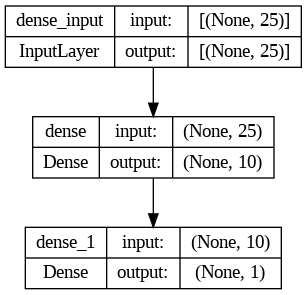

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Dense(10, input_shape=(seq_len,), activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

Model compilation:

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

Model training:

In [ ]:
history = model.fit(x, t, epochs=1000, batch_size=1000,
                    validation_data=(xval, tval))

Plots of loss and accuracy:

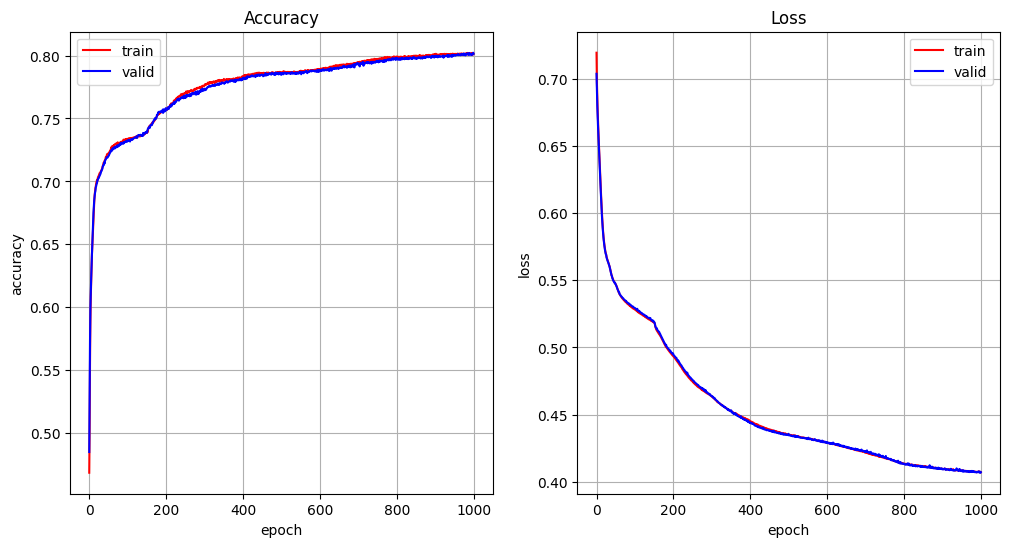

In [ ]:
hd = history.history

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(hd['accuracy'], "r", label="train")
plt.plot(hd['val_accuracy'], "b", label="valid")
plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hd['loss'], "r", label="train")
plt.plot(hd['val_loss'], "b", label="valid")
plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss")
plt.legend()

plt.show()

### Solution using a RNN

Model definition. The following points are important:

- ``stateful=False``: This indicates that it is not necessary to pass the last state to the next batch.

- ``return_sequences=False``: This indicates that it is not necessary to output the states at all time steps, only the last one.

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 10)                120       
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


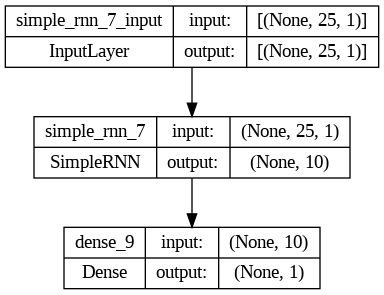

In [ ]:
model = Sequential()
model.add(SimpleRNN(10, activation="tanh", input_shape=(seq_len, 1),
                    return_sequences=False, stateful=False, unroll=True))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

Model compilation:

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              metrics=['accuracy'])

Model training:

In [ ]:
history = model.fit(x[:, :, None], t[:, None], epochs=200, batch_size=1000,
                    validation_data=(xval[:, :, None], tval[:, None]))

Plots of loss and accuracy:

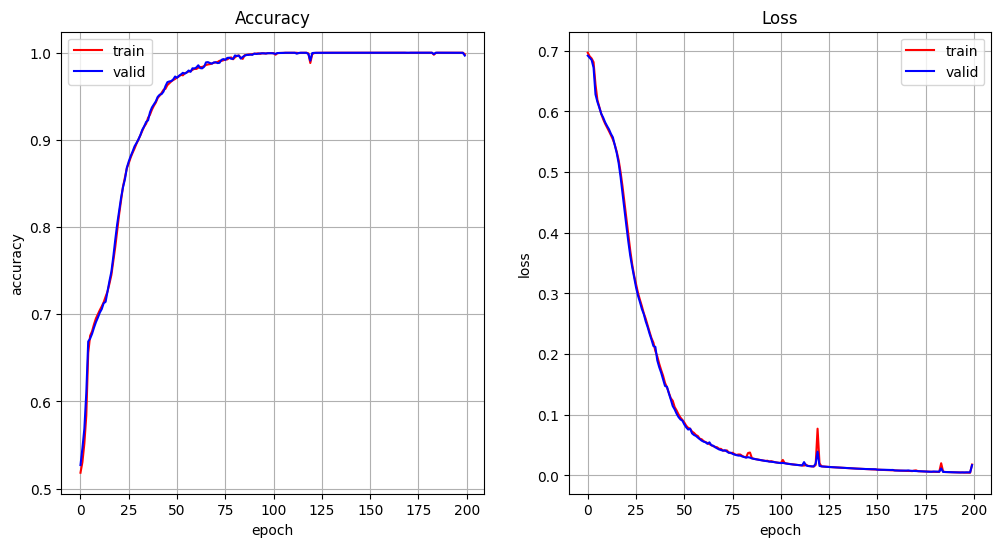

In [ ]:
hd = history.history

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(hd['accuracy'], "r", label="train")
plt.plot(hd['val_accuracy'], "b", label="valid")
plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hd['loss'], "r", label="train")
plt.plot(hd['val_loss'], "b", label="valid")
plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss")
plt.legend()

plt.show()

Note that, in spite of having a fewer number of trainable parameters, the RNN converges faster than the FF network and gets a much better solution.

## Backpropagation through time

Let us consider the Elman model. The network state ${\bf h}_{t}$ depends on the state at the previous time step, ${\bf h}_{t-1}$, and this depends in turn on ${\bf h}_{t-2}$, and so on. It is sometimes useful to imagine an unfolded representation of the RNN model, where we have a different copy of the network for every time step and the state is passed from one time step to the next one:

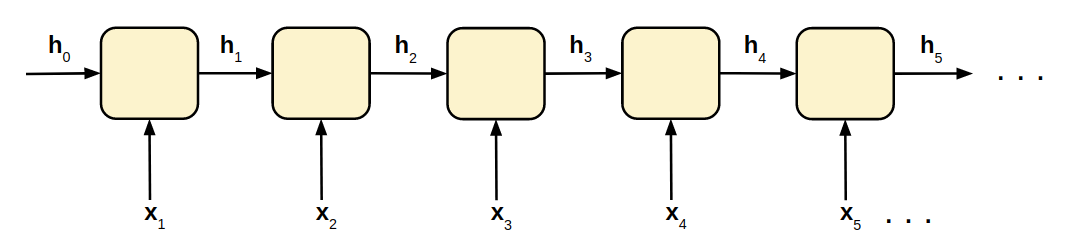

We see that ${\bf h}_{t}$, and hence ${\bf y}_{t}$, depends on all the past history (all past inputs and all past states). As all the network 'copies' share the same parameters, when computing the gradients of the loss function with respect to the hidden layer's weights and biases we need to backpropagate the error signal for an arbitrarily large number of time steps. This is of course unfeasible in any practical situation, so we usually do is to fix a time window of ``seq_len`` time steps and do not backpropagate the error further than this (*truncated backpropagation through time*).

The network state may however be passed continuously from one batch to the next and hence the network can in principle track events that ocurred many time steps before (long term dependencies).



## Example. Predict the parity of bit sequence

The second example is the parity problem described above. The input is a string with several bit sequences separated by the ``$`` symbol, and the output is the parity of the sequence since the last ``$``. One example of input/output is shown below:

```
INPUT:  $11011100000010001$1100000001010011$001001110$$010
OUTPUT: 01001011111110000101000000001100010000111010000011
```

The following function is used to generate input/output sequences for the parity problem:

In [ ]:
def generate_sequences(n, p0, p1):
  """
  n is the number of elements in the sequence
  p0 and p1 must be probabilities, with p0 + p1 <= 1
  the probability for the $ symbol is assumed to be p$ = 1 - p0 - p1
  """
  r = np.random.rand(n)
  x_sym = np.full(n, '$')
  x = np.full(n, 2)
  x_sym[r < p0 + p1] = '1'
  x[r < p0 + p1] = 1
  x_sym[r < p0] = '0'
  x[r < p0] = 0
  x_sym[0] = '$'
  x[0] = 2
  t = np.zeros(n, dtype=int)
  k = 0
  for i in range(n):
    if x[i] == 2:
      t[i] = 0
      k = 0
    else:
      k += x[i]
      t[i] = k%2

  x_string = ''.join(x_sym)
  t_string = ''.join([chr(c+48) for c in t])

  x_one_hot = 1*(np.arange(3)[:, None] == x[None, :])

  return x, t, x_one_hot, x_string, t_string

The following code generates a sequence of length 5000:

In [ ]:
num_pats = 5000
x, t, x_one_hot, x_string, t_string = generate_sequences(num_pats, 0.45, 0.45)

Model definition. Note that in this case we need a many-to-many architecture, since we need one output for each time step. The model needs also to be *stateful*.

- ``stateful=True``: This indicates that it is necessary to pass the last state to the next batch.

- ``return_sequences=True``: This indicates that it is necessary to output the states at all time steps, not only the last one.

Also, when using a stateful model we need to specify the batch size:

- ``batch_input_shape=(1, seq_len, 3)``

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (1, 50, 10)               140       
                                                                 
 dense_10 (Dense)            (1, 50, 1)                11        
                                                                 
Total params: 151 (604.00 Byte)
Trainable params: 151 (604.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


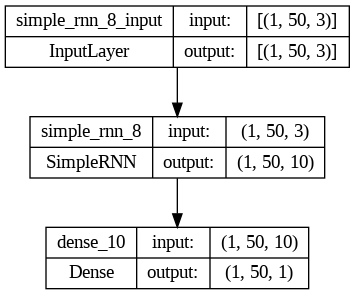

In [ ]:
seq_len = 50

model = Sequential()
model.add(SimpleRNN(10, activation='tanh', batch_input_shape=(1, seq_len, 3),
                    return_sequences=True, stateful=True, unroll=True))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

num_epochs = 100
num_batches = num_pats // seq_len # possibly ignore last elements in sequence

model_loss = np.zeros(num_epochs)
model_acc = np.zeros(num_epochs)

for epoch in range(num_epochs):
  model.reset_states() # reset state at the beginning of each epoch

  mean_tr_loss = []
  mean_tr_acc = []
  for j in range(num_batches):
    imin = j*seq_len
    imax = (j+1)*seq_len

    seq_x = x_one_hot[:, imin:imax].transpose()
    seq_t = t[imin:imax]

    tr_loss, tr_acc = model.train_on_batch(seq_x[None, :, :],
                                           seq_t[None, :, None])
    mean_tr_loss.append(tr_loss)
    mean_tr_acc.append(tr_acc)

  model_loss[epoch] = np.array(mean_tr_loss).mean()
  model_acc[epoch] = np.array(mean_tr_acc).mean()

  print("\nTraining epoch: %d / %d" % (epoch+1, num_epochs), end="")
  print(", loss = %f, acc = %f" % (model_loss[epoch], model_acc[epoch]),
        end="")

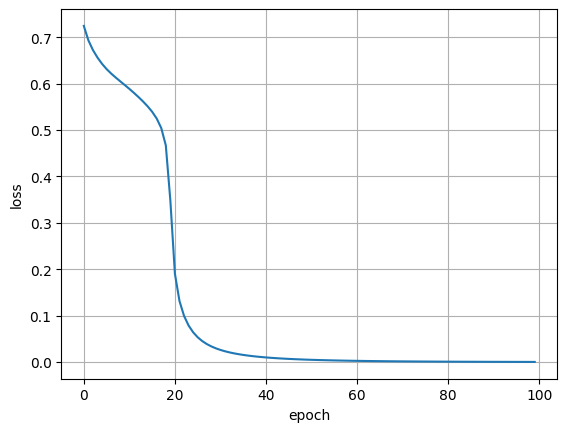

In [ ]:
plt.plot(model_loss)
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Evaluate model on test data:

In [ ]:
num_test_pats = 5000
(x_test, t_test, x_test_one_hot,
 x_test_string, t_test_string) = generate_sequences(num_test_pats, 0.45, 0.45)

num_test_batches = num_test_pats // seq_len

test_loss = []
test_acc = []
for j in range(num_test_batches):
  imin = j*seq_len
  imax = (j+1)*seq_len

  seq_x = x_test_one_hot[:, imin:imax].transpose()
  seq_t = t_test[imin:imax]

  loss, acc = model.test_on_batch(seq_x[None, :, :], seq_t[None, :, None])
  test_loss.append(loss)
  test_acc.append(acc)

print("Test loss = %f, test acc = %f" % (np.array(test_loss).mean(),
                                         np.array(test_acc).mean()))

Test loss = 0.000325, test acc = 1.000000


## The vanishing and exploding gradient problems

If we analyze the gradient flow in an Elman RNN, we observe that with each step back in the computational graph the gradient of the loss function gets multiplied by:

$$
\frac{\partial{{\bf h}_{t}}}{\partial{{\bf h}_{t-1}}} = W_{hh}^{t} f'({\bf v}_{t})
$$

When using activations such as the *sigmoid* or *tanh* functions, whose derivatives are always (*sigmoid*) or almost always (*tanh*) lower than 1, the gradient gets repeatedly multiplied by a small constant, and hence tends to zero after several time steps. This is known as the *vanishing gradient* problem.

We could consider using a linear activation, but even in this case the gradient is continuously multiplied by the matrix $W_{hh}^{t}$. In such a situation the behaviour depends on the largest singular value of this matrix:

- If it is greater than one, the gradient continuously increases (*exploding gradient* problem).

- If it is lower than one, the gradient decreases to zero (*vanishing gradient* problem).

The *exploding gradient* problem can be safely avoided by using a technique called *gradient clipping* which consists of scaling down the gradient if its norm is too big.

The *vanishing gradient* problem has no easy solution, but some RNN architectures have been designed to reduce its effects.


## Long short-term memory (LSTM)

LSTMs (Hochreiter and Schmidhuber, 1997) are designed to avoid the long term dependency problem due to the vanishing gradient. They are governed by the following equations:

$$
\begin{eqnarray}
{\bf f}_{t} &=& \sigma(W_{f} [{\bf x}_{t}; {\bf h}_{t-1}] + {\bf b}_{f}),\\
{\bf i}_{t} &=& \sigma(W_{i} [{\bf x}_{t}; {\bf h}_{t-1}] + {\bf b}_{i}),\\
\tilde{{\bf c}}_{t} &=& \tanh(W_{c} [{\bf x}_{t}; {\bf h}_{t-1}] + {\bf b}_{c}),\\
{\bf c}_{t} &=& {\bf f}_{t} \circ {\bf c}_{t-1} + {\bf i}_{t} \circ \tilde{{\bf c}}_{t},\\
{\bf o}_{t} &=& \sigma(W_{o} [{\bf x}_{t}; {\bf h}_{t-1}] + {\bf b}_{o}), \\
{\bf h}_{t} &=& {\bf o}_{t} \circ \tanh({\bf c}_{t}).
\end{eqnarray}
$$

In these equations $[{\bf x}_{t}; {\bf h}_{t-1}]$ means the concatenation of vectors ${\bf x}_{t}$ and ${\bf h}_{t-1}$, and the operator $\circ$ represents an element-wise multiplication.

The LSTM provides an uninterrupted gradient flow that allows the network learn long term dependencies.





## Gated recurrent unit (GRU)

The Gated Recurrent Unit (Cho et al., 2014) is a modification of the LSTM architecture that combines the forget and input gates into a single update gate, reducing the number of parameters.

$$
\begin{eqnarray*}
{\bf z}_{t} &=& \sigma(W_{z} [{\bf x}_{t}; {\bf h}_{t-1}] + {\bf b}_{z}),\\
{\bf r}_{t} &=& \sigma(W_{r} [{\bf x}_{t}; {\bf h}_{t-1}] + {\bf b}_{r}),\\
\tilde{{\bf h}}_{t} &=& \tanh(W_{h} [{\bf x}_{t}; {\bf r}_{t} \circ {\bf h}_{t-1}] + {\bf b}_{h}),\\
{\bf h}_{t} &=& (1 - {\bf z}_{t}) \circ {\bf h}_{t-1} + {\bf z}_{t} \circ \tilde{{\bf h}}_{t}.
\end{eqnarray*}
$$


## Text generation: predict the next char

See notebook [text_generation_quijote.ipynb](https://colab.research.google.com/github/luisferuam/luisferuam.github.io/blob/master/DLFBT/recurrent_neural_networks/text_generation_quijote.ipynb)

## Sequence-to-sequence (seq2seq) learning: binary to decimal translation

See also [this example](https://keras.io/examples/nlp/lstm_seq2seq/) for translation of short English sentences into short French sentences.

Function to generate random binary sequences and their corresponding decimal translations:

In [ ]:
def generate_data_bin_dec(n, maxnum, dpad, bpad):
  x = np.random.randint(0, maxnum, n)
  xdec_as_string = [str(a).zfill(dpad) for a in x]
  xbin_as_string = [bin(a).replace("0b","").zfill(bpad) for a in x]

  xbin = np.array([[ord(a) - 48 for a in b] for b in xbin_as_string])
  xdec = np.array([[ord(a) - 48 for a in b] for b in xdec_as_string])
  xdec_one_hot = 1*(np.arange(10)[None, None, :] == xdec[:, :, None])

  return xdec_as_string, xbin_as_string, xdec, xbin, xdec_one_hot

In [ ]:
seq_len_bin = 24
seq_len_dec = 8
_, _, d, b, doh = generate_data_bin_dec(10000, 2**15, seq_len_dec, seq_len_bin)
_, _, d_val, b_val, doh_val = generate_data_bin_dec(10000, 2**15, seq_len_dec, seq_len_bin)

Training data:

In [ ]:
print(b.shape)
print(d.shape)
print(doh.shape)

(10000, 24)
(10000, 8)
(10000, 8, 10)


Validation data:

In [ ]:
print(b_val.shape)
print(d_val.shape)
print(doh_val.shape)

(10000, 24)
(10000, 8)
(10000, 8, 10)


First 10 binary sequences in the training set:

In [ ]:
print(b[:10, :])

[[0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 1 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0]]


First 10 decimal sequences in the training set:

In [ ]:
print(d[:10, :])

[[0 0 0 3 1 8 6 8]
 [0 0 0 2 5 1 5 0]
 [0 0 0 2 6 2 8 2]
 [0 0 0 1 1 4 7 3]
 [0 0 0 0 7 2 3 6]
 [0 0 0 2 4 0 5 5]
 [0 0 0 1 4 6 3 3]
 [0 0 0 0 8 0 6 2]
 [0 0 0 0 2 0 3 3]
 [0 0 0 1 5 5 3 4]]


### Keras model 1

Use the encoder's hidden state as the decoder's input for all time steps.  

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 repeat_vector (RepeatVecto  (None, 8, 100)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 8, 100)            80400     
                                                                 
 dense (Dense)               (None, 8, 10)             1010      
                                                                 
Total params: 122210 (477.38 KB)
Trainable params: 122210 (477.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


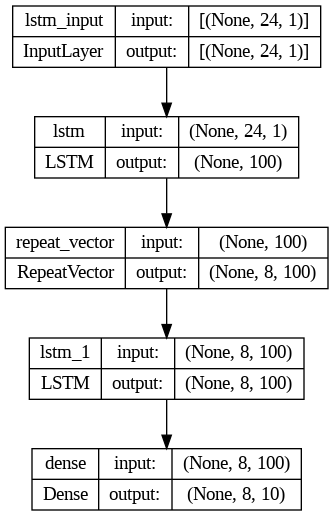

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(seq_len_bin, 1), return_sequences=False,
               stateful=False, unroll=True))
model.add(RepeatVector(seq_len_dec))
model.add(LSTM(100, return_sequences=True, stateful=False, unroll=True))
model.add(Dense(10, activation='softmax'))

print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

Model compilation:

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

Model training:

In [ ]:
history = model.fit(b[:, :, None], d[:, :, None], epochs=500,
                    batch_size=200,
                    validation_data=(b_val[:, :, None], d_val[:, :, None]))

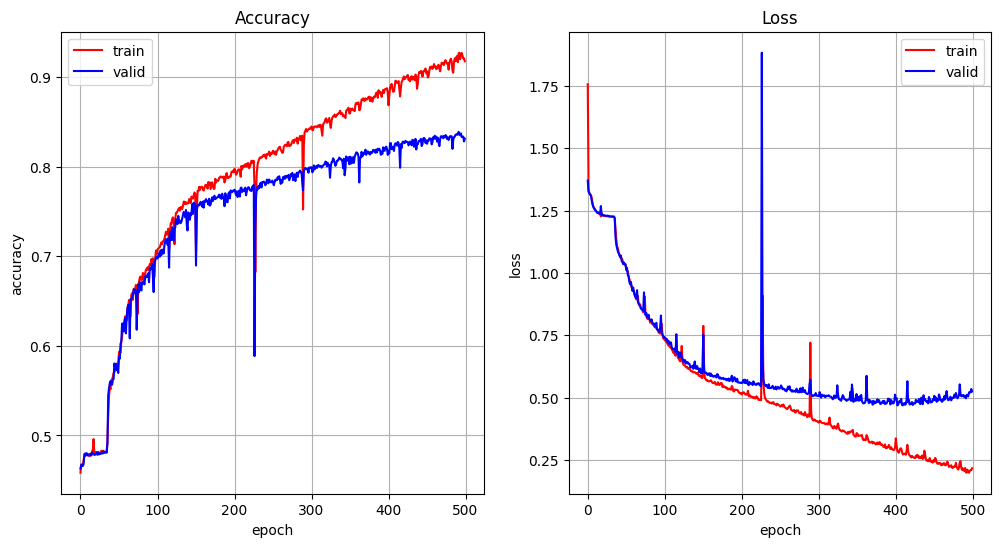

In [ ]:
hd = history.history

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(hd['accuracy'], "r", label="train")
plt.plot(hd['val_accuracy'], "b", label="valid")
plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hd['loss'], "r", label="train")
plt.plot(hd['val_loss'], "b", label="valid")
plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss")
plt.legend()

plt.show()

Model predictions:

In [ ]:
y = model.predict(b_val[:, :, None])
y = np.argmax(y, axis=2)
y[:20]

313/313 [==============================] - 2s 6ms/step


array([[0, 0, 0, 2, 7, 4, 4, 3],
       [0, 0, 0, 0, 7, 0, 3, 4],
       [0, 0, 0, 2, 5, 9, 7, 0],
       [0, 0, 0, 0, 1, 6, 9, 4],
       [0, 0, 0, 0, 7, 0, 0, 5],
       [0, 0, 0, 3, 0, 2, 4, 9],
       [0, 0, 0, 1, 9, 9, 6, 8],
       [0, 0, 0, 0, 7, 2, 5, 0],
       [0, 0, 0, 0, 7, 0, 0, 4],
       [0, 0, 0, 2, 2, 8, 1, 6],
       [0, 0, 0, 2, 0, 7, 4, 7],
       [0, 0, 0, 2, 4, 6, 8, 4],
       [0, 0, 0, 0, 7, 5, 2, 0],
       [0, 0, 0, 1, 2, 8, 4, 2],
       [0, 0, 0, 2, 6, 9, 7, 7],
       [0, 0, 0, 0, 7, 9, 5, 9],
       [0, 0, 0, 1, 4, 6, 4, 1],
       [0, 0, 0, 2, 2, 5, 4, 2],
       [0, 0, 0, 0, 4, 4, 0, 1],
       [0, 0, 0, 2, 1, 0, 5, 7]])

In [ ]:
d_val[:20]

array([[0, 0, 0, 2, 7, 4, 5, 5],
       [0, 0, 0, 0, 7, 0, 3, 4],
       [0, 0, 0, 2, 5, 9, 6, 4],
       [0, 0, 0, 0, 1, 6, 9, 0],
       [0, 0, 0, 0, 7, 0, 1, 5],
       [0, 0, 0, 3, 0, 2, 2, 9],
       [0, 0, 0, 1, 9, 9, 6, 8],
       [0, 0, 0, 0, 7, 2, 5, 2],
       [0, 0, 0, 0, 7, 0, 8, 6],
       [0, 0, 0, 2, 2, 8, 1, 0],
       [0, 0, 0, 2, 0, 7, 3, 7],
       [0, 0, 0, 2, 4, 6, 8, 4],
       [0, 0, 0, 0, 7, 5, 2, 8],
       [0, 0, 0, 1, 2, 8, 5, 6],
       [0, 0, 0, 2, 6, 9, 7, 7],
       [0, 0, 0, 0, 7, 9, 6, 3],
       [0, 0, 0, 1, 4, 6, 3, 3],
       [0, 0, 0, 2, 2, 5, 5, 0],
       [0, 0, 0, 0, 4, 4, 0, 3],
       [0, 0, 0, 2, 1, 0, 5, 9]])

Plot prediction vs real:

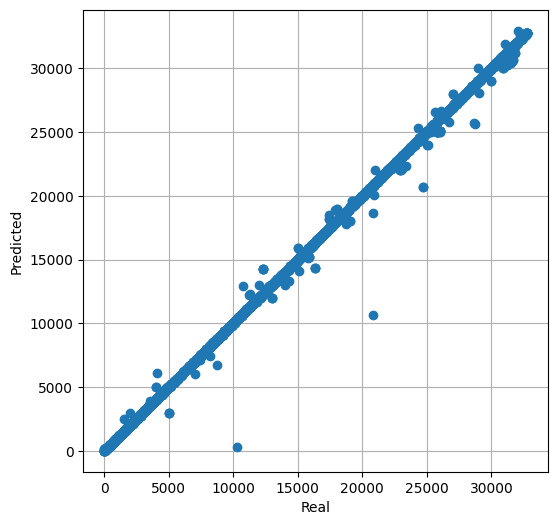

In [ ]:
r = np.array([10000000, 1000000, 100000, 10000, 1000, 100, 10, 1])

plt.figure(figsize=(6, 6))
plt.plot(np.dot(d_val, r), np.dot(y, r), 'o')
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.show()

Error:

In [ ]:
print(np.mean(np.abs(np.dot(d_val, r) - np.dot(y, r))))
print(np.max(np.abs(np.dot(d_val, r) - np.dot(y, r))))

27.1777
10172


### Keras model 2

The encoder's hidden state is used as the decoder's initial state. The decoder's input is a set of zeros.

It is necessary to use the Keras functional API.

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 24, 1)]              0         []                            
                                                                                                  
 input_34 (InputLayer)       [(None, 8, 1)]               0         []                            
                                                                                                  
 lstm_14 (LSTM)              [(None, 200),                161600    ['input_33[0][0]']            
                              (None, 200),                                                        
                              (None, 200)]                                                        
                                                                                           

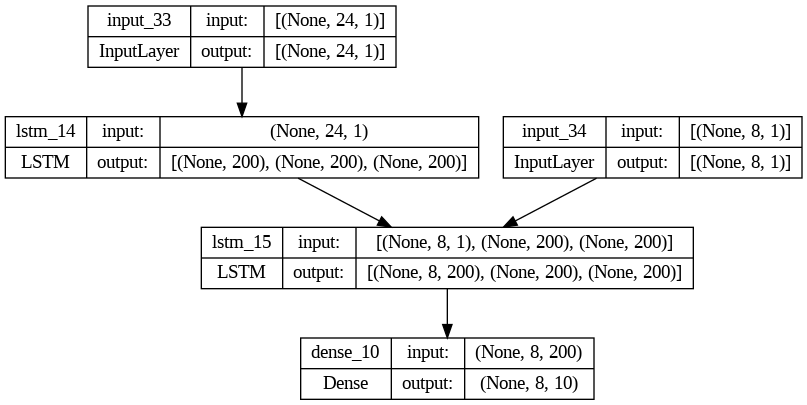

In [ ]:
encoder_input = Input(shape=(seq_len_bin, 1))
encoder = LSTM(200, return_sequences=False, stateful=False, unroll=True,
               return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_input)

decoder_input = Input(shape=(seq_len_dec, 1))
decoder = LSTM(200, return_sequences=True, stateful=False, unroll=True,
               return_state=True)
decoder_output, _, _ = decoder(decoder_input, initial_state=[state_h, state_c])
output_layer = Dense(10, activation='softmax')
output = output_layer(decoder_output)

model = Model([encoder_input, decoder_input], output)

print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

Model compilation:

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])

Model training:

In [ ]:
history = model.fit([b[:, :, None], np.zeros((10000, 8, 1))], d[:, :, None],
                    epochs=200, batch_size=200,
                    validation_data=([b_val[:, :, None], np.zeros((10000, 8, 1))], d_val[:, :, None]))

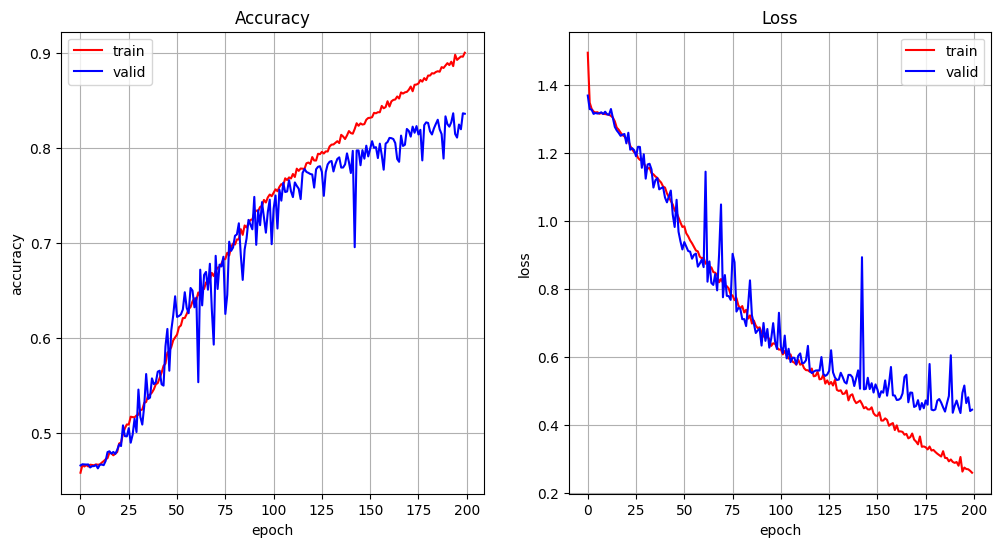

In [ ]:
hd = history.history

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(hd['accuracy'], "r", label="train")
plt.plot(hd['val_accuracy'], "b", label="valid")
plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hd['loss'], "r", label="train")
plt.plot(hd['val_loss'], "b", label="valid")
plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss")
plt.legend()

plt.show()

Model predictions:

In [ ]:
y = model.predict([b_val[:, :, None], np.zeros((10000, 8, 1))])
y = np.argmax(y, axis=2)
y[:20]

313/313 [==============================] - 2s 5ms/step


array([[0, 0, 0, 2, 7, 4, 5, 5],
       [0, 0, 0, 0, 7, 0, 3, 4],
       [0, 0, 0, 2, 5, 9, 6, 0],
       [0, 0, 0, 0, 1, 6, 9, 4],
       [0, 0, 0, 0, 7, 0, 2, 3],
       [0, 0, 0, 3, 0, 2, 4, 9],
       [0, 0, 0, 1, 9, 9, 6, 8],
       [0, 0, 0, 0, 7, 2, 5, 0],
       [0, 0, 0, 0, 7, 0, 9, 6],
       [0, 0, 0, 2, 2, 8, 1, 6],
       [0, 0, 0, 2, 0, 8, 4, 1],
       [0, 0, 0, 2, 4, 6, 6, 2],
       [0, 0, 0, 0, 7, 5, 3, 6],
       [0, 0, 0, 1, 2, 8, 6, 2],
       [0, 0, 0, 2, 6, 9, 7, 1],
       [0, 0, 0, 0, 7, 9, 6, 9],
       [0, 0, 0, 1, 4, 6, 3, 3],
       [0, 0, 0, 2, 2, 5, 5, 2],
       [0, 0, 0, 0, 4, 4, 1, 1],
       [0, 0, 0, 2, 1, 0, 6, 7]])

In [ ]:
d_val[:20]

array([[0, 0, 0, 2, 7, 4, 5, 5],
       [0, 0, 0, 0, 7, 0, 3, 4],
       [0, 0, 0, 2, 5, 9, 6, 4],
       [0, 0, 0, 0, 1, 6, 9, 0],
       [0, 0, 0, 0, 7, 0, 1, 5],
       [0, 0, 0, 3, 0, 2, 2, 9],
       [0, 0, 0, 1, 9, 9, 6, 8],
       [0, 0, 0, 0, 7, 2, 5, 2],
       [0, 0, 0, 0, 7, 0, 8, 6],
       [0, 0, 0, 2, 2, 8, 1, 0],
       [0, 0, 0, 2, 0, 7, 3, 7],
       [0, 0, 0, 2, 4, 6, 8, 4],
       [0, 0, 0, 0, 7, 5, 2, 8],
       [0, 0, 0, 1, 2, 8, 5, 6],
       [0, 0, 0, 2, 6, 9, 7, 7],
       [0, 0, 0, 0, 7, 9, 6, 3],
       [0, 0, 0, 1, 4, 6, 3, 3],
       [0, 0, 0, 2, 2, 5, 5, 0],
       [0, 0, 0, 0, 4, 4, 0, 3],
       [0, 0, 0, 2, 1, 0, 5, 9]])

Plot predictions vs real:

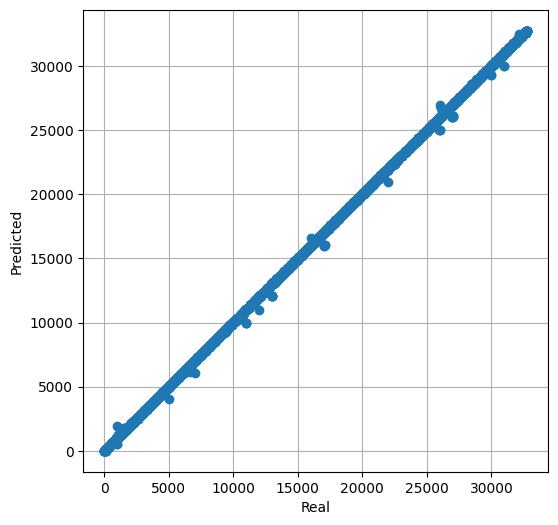

In [ ]:
r = np.array([10000000, 1000000, 100000, 10000, 1000, 100, 10, 1])

plt.figure(figsize=(6, 6))
plt.plot(np.dot(d_val, r), np.dot(y, r), 'o')
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.show()

Error:

In [ ]:
print(np.mean(np.abs(np.dot(d_val, r) - np.dot(y, r))))
print(np.max(np.abs(np.dot(d_val, r) - np.dot(y, r))))

13.5304
1016


### Keras model 3

As model 2, but the decoder's input is the decimal string shifted by one position.

In [ ]:
dec_input = np.concatenate((np.zeros((10000, 1, 10)), doh[:, :-1, :]), axis=1)
dec_input_val = np.concatenate((np.zeros((10000, 1, 10)), doh_val[:, :-1, :]), axis=1)

Keras model:

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_37 (InputLayer)       [(None, 24, 1)]              0         []                            
                                                                                                  
 input_38 (InputLayer)       [(None, 8, 10)]              0         []                            
                                                                                                  
 lstm_18 (LSTM)              [(None, 200),                161600    ['input_37[0][0]']            
                              (None, 200),                                                        
                              (None, 200)]                                                        
                                                                                           

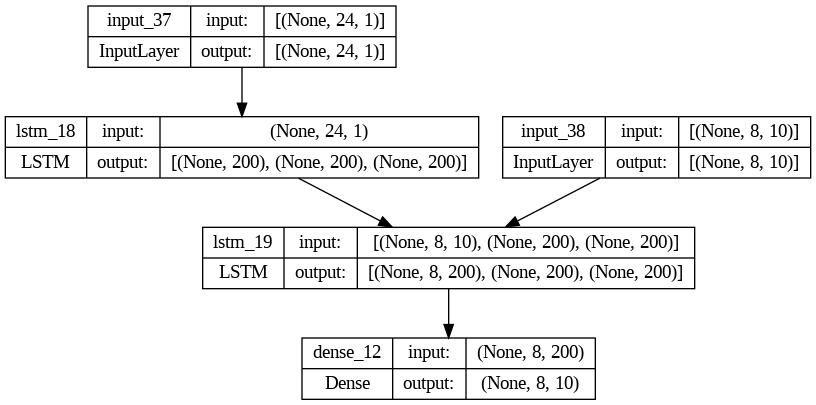

In [ ]:
encoder_input = Input(shape=(seq_len_bin, 1))
encoder = LSTM(200, return_sequences=False, stateful=False, unroll=True,
               return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_input)

decoder_input = Input(shape=(seq_len_dec, 10))
decoder = LSTM(200, return_sequences=True, stateful=False, unroll=True,
               return_state=True)
decoder_output, _, _ = decoder(decoder_input, initial_state=[state_h, state_c])
output_layer = Dense(10, activation='softmax')
output = output_layer(decoder_output)

model = Model([encoder_input, decoder_input], output)

print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

Model compilation:

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])

Model training:

In [ ]:
history = model.fit([b[:, :, None], dec_input], d[:, :, None], epochs=200,
                    batch_size=200, validation_data=([b_val[:, :, None], dec_input_val], d_val[:, :, None]))

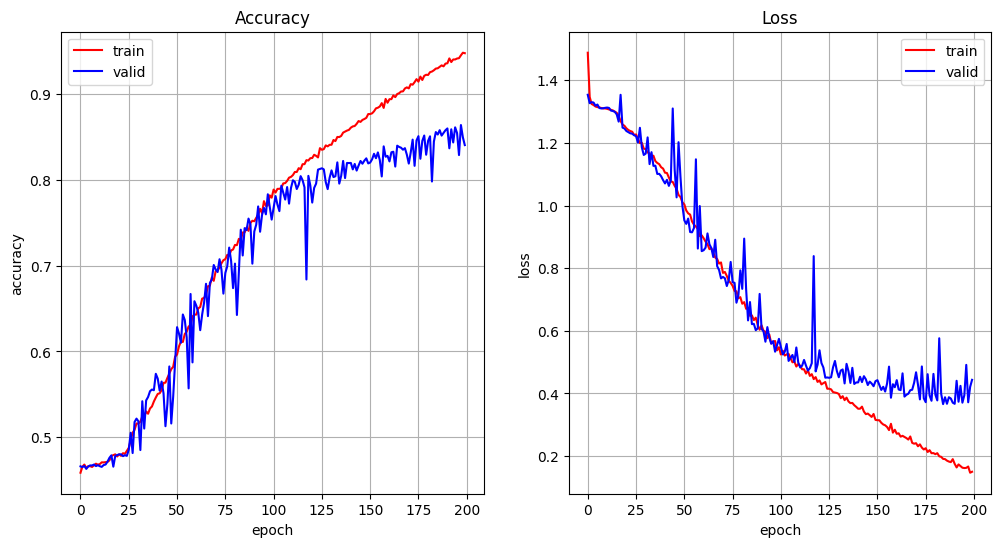

In [ ]:
hd = history.history

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(hd['accuracy'], "r", label="train")
plt.plot(hd['val_accuracy'], "b", label="valid")
plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hd['loss'], "r", label="train")
plt.plot(hd['val_loss'], "b", label="valid")
plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss")
plt.legend()

plt.show()

Model predictions (tricky, we are using the shifted input instead of the generated chars):

In [ ]:
y = model.predict([b_val[:, :, None], dec_input_val])
y = np.argmax(y, axis=2)
y[:20]

313/313 [==============================] - 2s 5ms/step


array([[0, 0, 0, 2, 7, 4, 4, 1],
       [0, 0, 0, 0, 7, 0, 0, 0],
       [0, 0, 0, 2, 5, 9, 6, 0],
       [0, 0, 0, 0, 1, 6, 9, 4],
       [0, 0, 0, 0, 7, 0, 2, 5],
       [0, 0, 0, 3, 0, 2, 0, 5],
       [0, 0, 0, 1, 9, 9, 6, 0],
       [0, 0, 0, 0, 7, 2, 7, 2],
       [0, 0, 0, 0, 7, 0, 6, 2],
       [0, 0, 0, 2, 2, 8, 0, 0],
       [0, 0, 0, 2, 0, 8, 6, 7],
       [0, 0, 0, 2, 4, 6, 8, 4],
       [0, 0, 0, 7, 7, 5, 2, 0],
       [0, 0, 0, 1, 2, 8, 2, 2],
       [0, 0, 0, 2, 6, 9, 7, 7],
       [0, 0, 0, 0, 7, 9, 5, 3],
       [0, 0, 0, 1, 4, 6, 3, 3],
       [0, 0, 0, 2, 2, 5, 4, 4],
       [0, 0, 0, 0, 4, 4, 1, 3],
       [0, 0, 0, 2, 1, 0, 2, 9]])

In [ ]:
d_val[:20]

array([[0, 0, 0, 2, 7, 4, 5, 5],
       [0, 0, 0, 0, 7, 0, 3, 4],
       [0, 0, 0, 2, 5, 9, 6, 4],
       [0, 0, 0, 0, 1, 6, 9, 0],
       [0, 0, 0, 0, 7, 0, 1, 5],
       [0, 0, 0, 3, 0, 2, 2, 9],
       [0, 0, 0, 1, 9, 9, 6, 8],
       [0, 0, 0, 0, 7, 2, 5, 2],
       [0, 0, 0, 0, 7, 0, 8, 6],
       [0, 0, 0, 2, 2, 8, 1, 0],
       [0, 0, 0, 2, 0, 7, 3, 7],
       [0, 0, 0, 2, 4, 6, 8, 4],
       [0, 0, 0, 0, 7, 5, 2, 8],
       [0, 0, 0, 1, 2, 8, 5, 6],
       [0, 0, 0, 2, 6, 9, 7, 7],
       [0, 0, 0, 0, 7, 9, 6, 3],
       [0, 0, 0, 1, 4, 6, 3, 3],
       [0, 0, 0, 2, 2, 5, 5, 0],
       [0, 0, 0, 0, 4, 4, 0, 3],
       [0, 0, 0, 2, 1, 0, 5, 9]])

Plot predictions vs real:

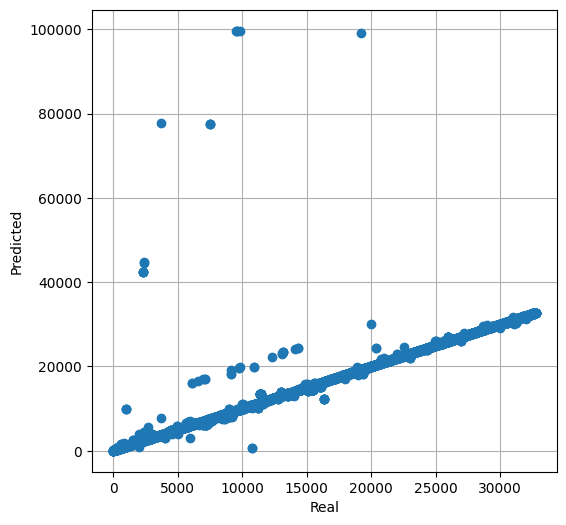

In [ ]:
r = np.array([10000000, 1000000, 100000, 10000, 1000, 100, 10, 1])

plt.figure(figsize=(6, 6))
plt.plot(np.dot(d_val, r), np.dot(y, r), 'o')
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.show()

Error (in spite of the trick, the model is not better than model 1):

In [ ]:
print(np.mean(np.abs(np.dot(d_val, r) - np.dot(y, r))))
print(np.max(np.abs(np.dot(d_val, r) - np.dot(y, r))))

30.3637
10026


## Exercise

Obtain the model's predictions by using the last character generated by the decoder as the next input (see [this example](https://keras.io/examples/nlp/lstm_seq2seq/)).  